In [101]:
from music21 import stream, note, environment, metadata, meter, converter
from fractions import Fraction
us = environment.UserSettings()
us['musicxmlPath'] = '/Applications/MuseScore 3.app/Contents/MacOS/mscore'
import numpy as np


In [102]:
class MarkovMelodyComposer:
    def __init__(self, states):
        self.states = states
        self.initial_probabilities = np.zeros(len(states))
        self.transition_matrix = np.zeros((len(states),len(states)))
        self.state_indexes = {state: i for (i, state) in enumerate (states)}
        
    def train (self, notes):
        #Calculate initial probablilities
        for note in notes:
            state = (note.pitch.nameWithOctave, note.duration.quarterLength)
            self.initial_probabilities[self.state_indexes[state]] +=1
        total_init = np.sum(self.initial_probabilities)
        if total_init:
            self.initial_probabilities = self.initial_probabilities/total_init
        self.initial_probabilities = np.nan_to_num(self.initial_probabilities)
        
        #Calculate transition matrix
        for i in range(len(notes)-1):
            current_note = notes[i]
            next_note = notes[i+1]
            current_state = (current_note.pitch.nameWithOctave,
                             current_note.duration.quarterLength)
            next_state = (next_note.pitch.nameWithOctave, 
                          next_note.duration.quarterLength)    
            self.transition_matrix[self.state_indexes[current_state], self.state_indexes[next_state]] +=1
        rows_sums = self.transition_matrix.sum(axis=1)
        with np.errstate(divide="ignore", invalid="ignore"):
            self.transition_matrix = np.where(
                rows_sums[:,None],
                self.transition_matrix/rows_sums[:,None],
                0,)

    def generate (self, total_beats, key):
        melody=[]
        total_duration = 0 
        #Generate starting state
        starting_state = (key, 1)  # Assume quarter note duration
    
        if starting_state not in self.state_indexes:
            print("Invalid key or state not found in model.")
            return []
        
        # initial_index = np.random.choice(
        #     list(self.state_indexes.values()),
        #     p=self.initial_probabilities)
        # starting_state = self.states[initial_index]
        melody.append(starting_state)
        total_duration +=  starting_state[1]

        while total_duration < total_beats:
            last_note = melody[-1]
            
            if self.transition_matrix[self.state_indexes[last_note]].sum() > 0:
                index = np.random.choice(
                    list(self.state_indexes.values()),
                    p=self.transition_matrix[self.state_indexes[last_note]],
                    )
                next_state = self.states[index]
            else:
                # fallback to random state based on initial probabilities
                index = np.random.choice(
                    list(self.state_indexes.values()),
                    p=self.initial_probabilities
                )
                next_state = self.states[index]
            melody.append(next_state)
            total_duration +=  next_state[1]
        return melody
        

In [103]:
# Create training data set from the midi file provided for Bhairav raag
def create_training_data (midi_path):
    midi_stream = converter.parse(midi_path)
    notes = []
    
    # Flatten the stream and iterate over notes only
    for element in midi_stream.flatten().notes:
        if isinstance(element, note.Note):
            notes.append(element)
        elif isinstance(element, note.Rest):
            # You can decide how to handle rests (skip or include)
            pass
    
    return notes


In [109]:
# Extract the possible note states in the form of tuples (pitch and duration)
def create_states (midi_path):
    # Load your MIDI file
    score = converter.parse(midi_path)
    
    # Extract all notes
    notes = score.flatten().notes
    
    # Build a set of unique states
    state_set = set()
    for n in notes:
        if isinstance(n, note.Note):
            pitch = n.pitch.nameWithOctave
            duration = float(n.duration.quarterLength)
            # Round to 3 decimal places for readability
            duration = round(duration, 3)
            state_set.add((pitch, duration))
    
    # Sort and format as a Python list
    states = sorted(state_set)
    
    return states
    # print("states = [")
    # for state in states:
    #     print(f"    {state},")
    # print("]")

In [115]:
# Link to the midi file should be mentioned here. Also need to provide the correct key by analyzing the midi file.

midi_path = 'Raag Bhairav_training data.mid'
key = "D4"

states = create_states(midi_path)
training_data= create_training_data(midi_path)
model = MarkovMelodyComposer(states)
model.train(training_data)


ts_input = input("Enter the time signature (e.g., 4/4, 3/4): ")
beats_per_bar, denominator = map(int, ts_input.split('/'))
total_beats = num_bars * beats_per_bar

composition = model.generate(total_beats, key)

#print(composition)
score = stream.Score()
score.metadata = metadata.Metadata(title="Markov Chain Melody")
part = stream.Part()
time_signature = meter.TimeSignature(f"{beats_per_bar}/{denominator}")

part.append(time_signature)  # Apply time signature to the part
for n, d in composition:
    part.append(note.Note(n, quarterLength=d))
score.append(part)
score.show('musicxml')

    

Enter the time signature (e.g., 4/4, 3/4):  4/4


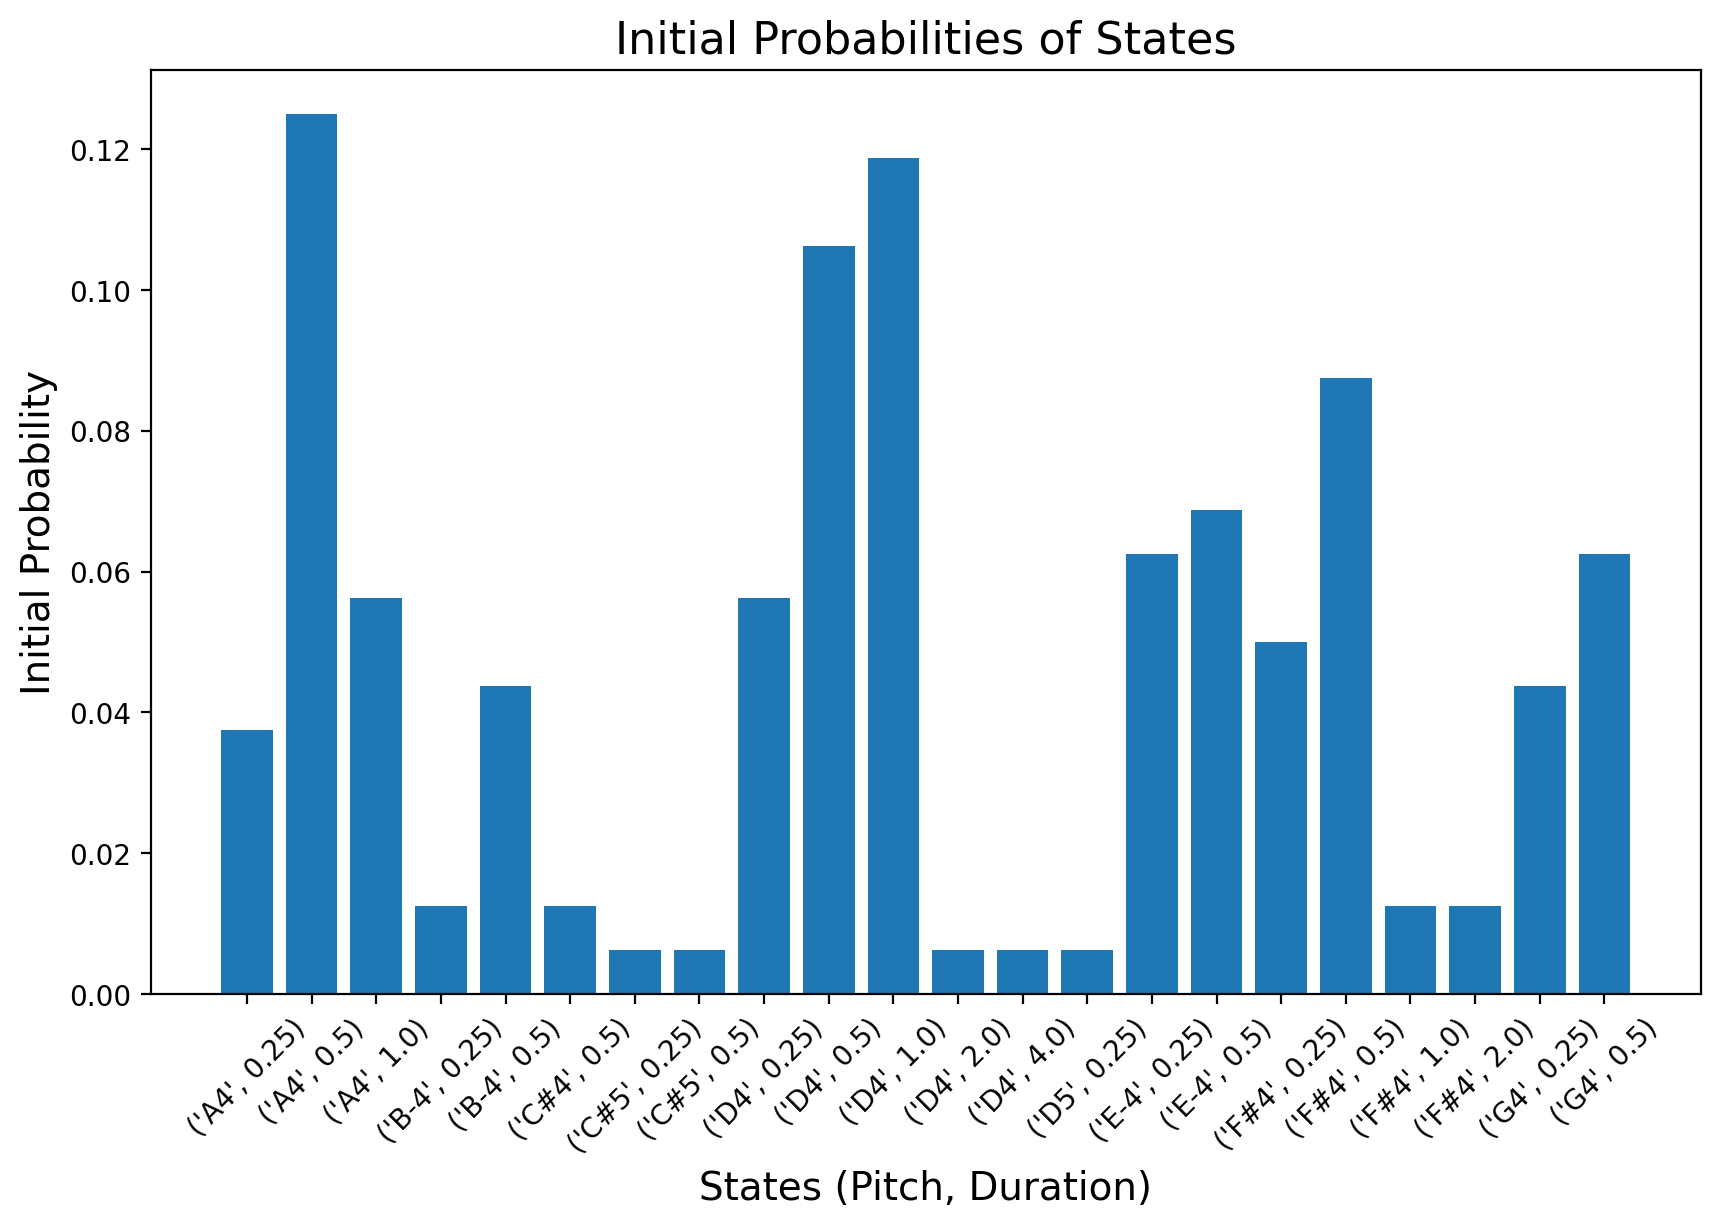

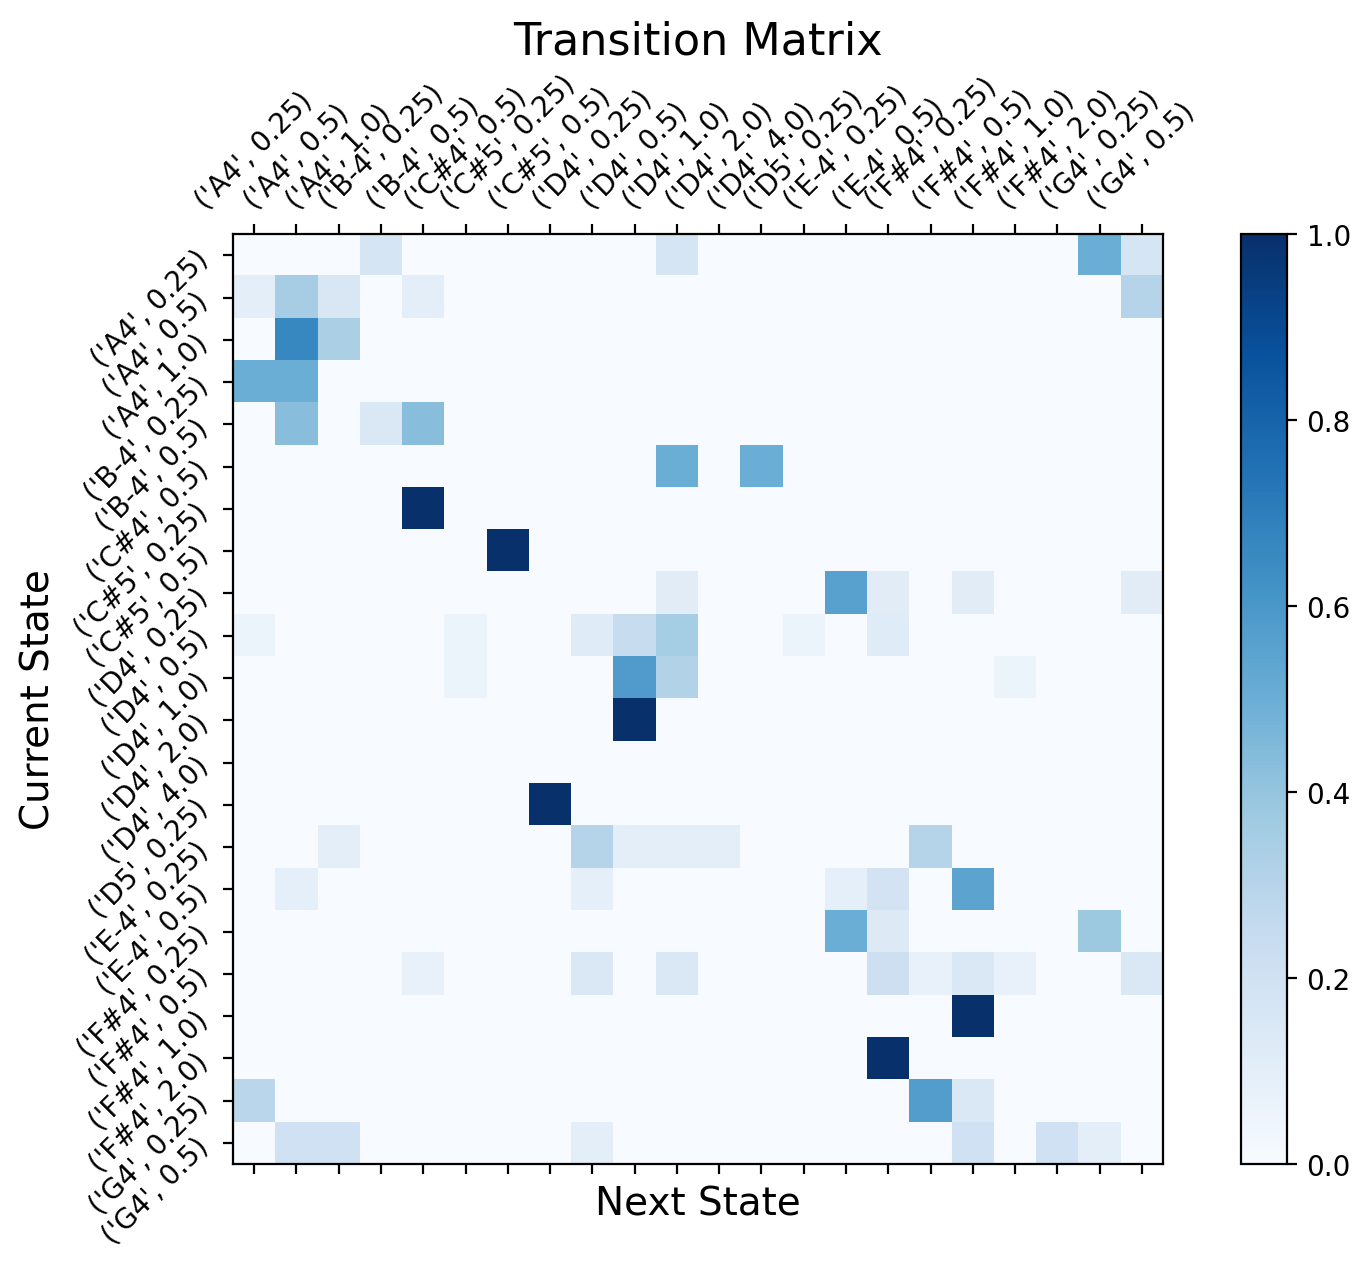

In [113]:

import numpy as np
import matplotlib.pyplot as plt

# Visualize Initial Probabilities
def plot_initial_probabilities(model):
    # Convert state keys to strings to ensure they are hashable
    state_labels = [str(state) for state in model.state_indexes.keys()]
    
    # Plotting initial probabilities as a bar plot
    plt.figure(figsize=(10, 6))
    plt.bar(state_labels, model.initial_probabilities)
    plt.xlabel('States (Pitch, Duration)', fontsize=14)
    plt.ylabel('Initial Probability', fontsize=14)
    plt.title('Initial Probabilities of States', fontsize=16)
    plt.xticks(rotation=45)
    plt.show()

# Visualize Transition Matrix using matshow
def plot_transition_matrix(model):
    # Get the transition matrix
    transition_matrix = model.transition_matrix

    # Create a heatmap using matshow
    plt.figure(figsize=(10, 6))
    plt.matshow(transition_matrix, cmap="Blues", fignum=1)
    plt.title('Transition Matrix', fontsize=16)
    plt.xlabel('Next State', fontsize=14)
    plt.ylabel('Current State', fontsize=14)
    plt.xticks(ticks=np.arange(len(model.states)), labels=[str(state) for state in model.states], rotation=45)
    plt.yticks(ticks=np.arange(len(model.states)), labels=[str(state) for state in model.states], rotation=45)
    plt.colorbar()
    plt.show()

# Example usage:
plot_initial_probabilities(model)
plot_transition_matrix(model)

